In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.enrichment import *
import plotly.express as px
#from pymodulon.plotting import *
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations

In [2]:
ica_data = load_json_model('../data/yarrowia2025.json')


In [3]:
ica_data.sample_table

,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2
yl_001,20210204-YL-CN-1,Glucose_Nlimit,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft-N limited,Nitrogen,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-CN-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-CN-1A_2.fq.gz
yl_002,20210204-YL-CN-2,Glucose_Nlimit,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft-N limited,Nitrogen,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-CN-2A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-CN-2A_2.fq.gz
yl_003,20210204-YL-fill-1,Glucose_lowDO,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,Low,6,30,ylipolytic2025_repeat/20210204-YL-fill-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-fill-1A_2.fq.gz
yl_004,20210204-YL-fill-2,Glucose_lowDO,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,Low,6,30,ylipolytic2025_repeat/20210204-YL-fill-2A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-fill-2A_2.fq.gz
yl_005,20210204-YL-ref-1,Glucose_shaken_reference,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-ref-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-ref-1A_2.fq.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yl_096,PD017 A3 S05 #2,µ0.2_DO5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,5,6,30,ylipolytic2025_repeat/PD017A3S051A_1.fq.gz,ylipolytic2025_repeat/PD017A3S051A_2.fq.gz
yl_097,PD017 A3 S06 #1,µ0.2_DO2.5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,2.5,6,30,ylipolytic2025_repeat/PD017A3S052A_1.fq.gz,ylipolytic2025_repeat/PD017A3S052A_2.fq.gz
yl_098,PD017 A3 S06 #2,µ0.2_DO2.5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,2.5,6,30,ylipolytic2025_repeat/PD017A3S061A_1.fq.gz,ylipolytic2025_repeat/PD017A3S061A_2.fq.gz
yl_099,PD017 A3 S07 #1,µ0.2_DO0,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,0,6,30,ylipolytic2025_repeat/PD017A3S062A_1.fq.gz,ylipolytic2025_repeat/PD017A3S062A_2.fq.gz


Analyzing shaken vs continuous cultures


In [4]:

def pca_scatter3(df, labels=None, scale=True, label_points=False,name='pca_plot',
                 palette='tab10', figsize=(12, 4), s=45, alpha=0.9):
    """
    PCA on a genes × samples table with a 3‑panel pairwise plot (PC1‑PC3).

    Parameters
    ----------
    df : pandas.DataFrame
        Rows = genes/features, Columns = samples/conditions.
    labels : list‑like or pandas.Series, optional
        A list/category for each column (same length/order as df.columns).
        • If `label_points` is False (default) they are used for *colours*.
        • If `label_points` is True they are drawn as *text* at each point.
    scale : bool, default True
        Standard‑scale each gene before PCA (zero mean, unit variance).
    label_points : bool, default False
        If True, annotate each point with the corresponding entry in `labels`.
        If False, unique entries in labels are mapped to colours with a legend.
    palette : str or sequence
        Matplotlib colour palette name or explicit colour list.
    figsize : tuple, default (12, 4)
        Overall figure size (three equal‑width panels).
    s : int or float, default 45
        Marker size for scatter points.
    alpha : float, default 0.9
        Marker transparency.

    Returns
    -------
    pca : sklearn.decomposition.PCA
        The fitted PCA object (for further inspection if needed).
    """
    # ---------- 1. prepare the data (samples as rows) ----------
    X = df.T.values                                       # (n_samples, n_genes)
    if scale:
        X = StandardScaler().fit_transform(X)

    # ---------- 2. run PCA ----------
    pca = PCA(n_components=3, random_state=0)
    PCs = pca.fit_transform(X)                            # shape = (n_samples, 3)
    expl = pca.explained_variance_ratio_ * 100            # %

    # ---------- 3. reporting ----------
    print("Variance explained: "
          f"PC1 = {expl[0]:.1f} %,  PC2 = {expl[1]:.1f} %,  PC3 = {expl[2]:.1f} %")

    # ---------- 4. figure set‑up ----------
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharex=False, sharey=False)

    # colours / text for each point
    if labels is None:
        labels = np.repeat('', len(df.columns))           # blank labels
    labels = pd.Series(labels, index=df.columns)

    if label_points:
        colour_map = np.full(len(labels), 'tab:blue')     # one colour, text only
    else:
        uniq = labels.unique()
        palette = plt.get_cmap(palette).colors if isinstance(palette, str) else palette
        colour_map = labels.apply(lambda z: palette[list(uniq).index(z) % len(palette)])

    # ---------- 5. scatter on PC pairs ----------
    axes_pairs = [(0, 1), (0, 2), (1, 2)]
    for ax, (i, j) in zip(axes, axes_pairs):
        ax.scatter(PCs[:, i], PCs[:, j], c=colour_map, s=s, alpha=alpha, edgecolor='k')
        ax.set_xlabel(f"PC{i+1} ({expl[i]:.1f} %)")
        ax.set_ylabel(f"PC{j+1} ({expl[j]:.1f} %)")
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(5))
        ax.axhline(0, color='grey', lw=0.6)
        ax.axvline(0, color='grey', lw=0.6)

        if label_points:
            for (x, y), txt in zip(PCs[:, [i, j]], labels):
                ax.text(x, y, str(txt), fontsize=8,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    # common legend (colour‑based) if not text labelling
    if not label_points and labels.nunique() > 0:
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=palette[k % len(palette)],
                              markeredgecolor='k', markersize=np.sqrt(s))
                   for k, _ in enumerate(labels.unique())]
        axes[-1].legend(handles, labels.unique(), frameon=False,
                        bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(name+'.png',dpi=300,transparent=True)
    return pca


Variance explained: PC1 = 24.8 %,  PC2 = 13.0 %,  PC3 = 9.0 %


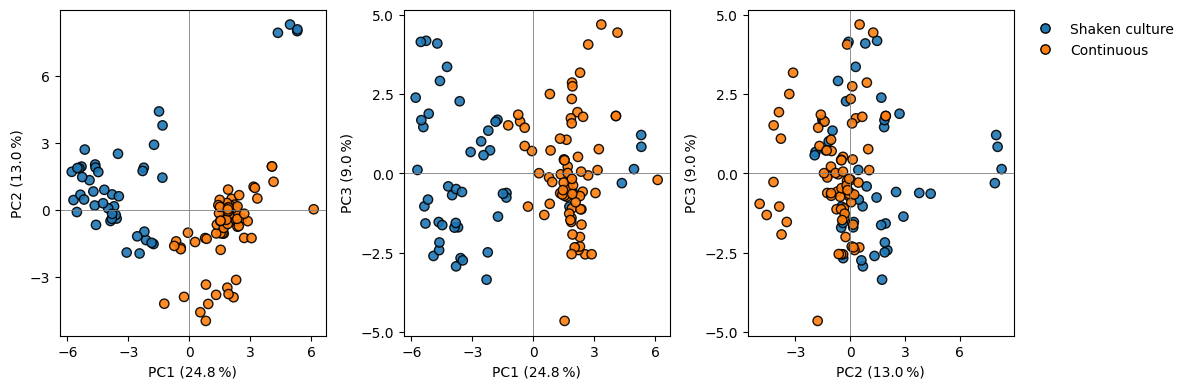

In [5]:
pca_model = pca_scatter3(ica_data.A, labels=ica_data.sample_table['Mode of operation'].tolist(), scale=True, label_points=False,name='tpm_pca')
#plt.savefig('tpm_pca.png',dpi=300,transparent=True)

Text(0.5, 1.0, 'PC3 loadings')

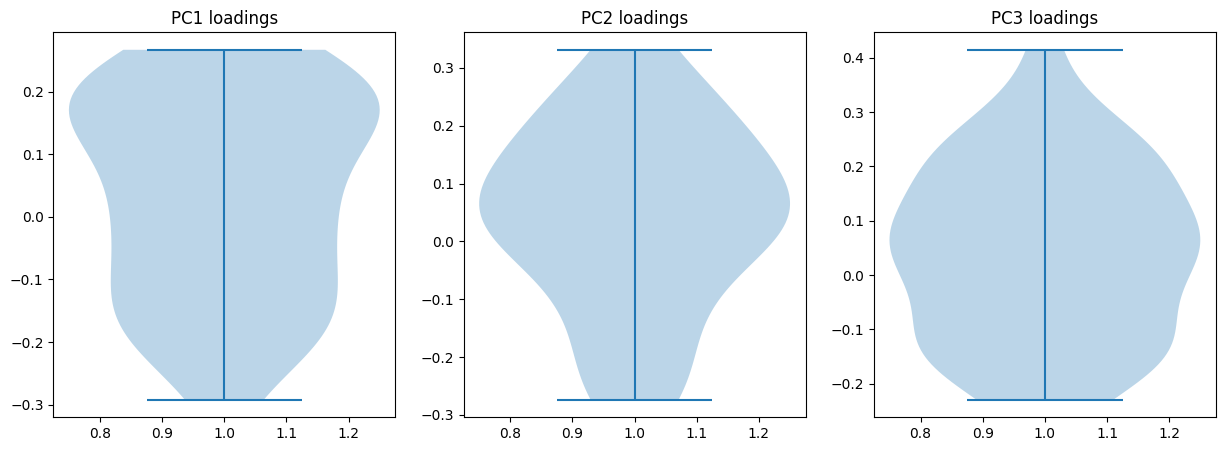

In [6]:
loadings = pd.DataFrame(pca_model.components_).T

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.violinplot(loadings[0])
plt.title('PC1 loadings')

plt.subplot(1,3,2)
plt.violinplot(loadings[1])
plt.title('PC2 loadings')

plt.subplot(1,3,3)
plt.violinplot(loadings[2])
plt.title('PC3 loadings')

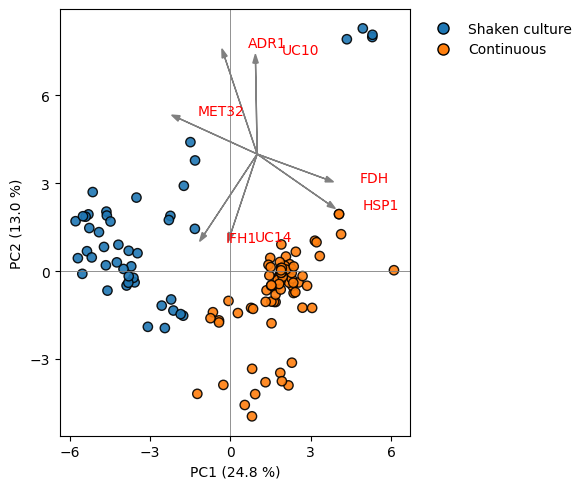

In [7]:
df = ica_data.A
X  = StandardScaler().fit_transform(df.T.values)

labels = pd.Series(ica_data.sample_table['Mode of operation'])   # keep as Series

PCs  = pca_model.fit_transform(X)
expl = pca_model.explained_variance_ratio_ * 100

# ---------- 2. build a colour map ----------------------------------------
uniq     = labels.unique()
palette  = plt.get_cmap('tab10').colors          # or any other MPL palette
colours  = labels.map(lambda z: palette[list(uniq).index(z) % len(palette)])

# ---------- 3. plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(PCs[:, 0], PCs[:, 1], c=colours, s=45, alpha=0.9, edgecolor='k')

ax.set_xlabel(f"PC1 ({expl[0]:.1f} %)")
ax.set_ylabel(f"PC2 ({expl[1]:.1f} %)")
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.axhline(0, color='grey', lw=0.6); ax.axvline(0, color='grey', lw=0.6)

# ---------- 4. legend -----------------------------------------------------
handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=palette[i % len(palette)],
                      markeredgecolor='k', markersize=8)
           for i in range(len(uniq))]
ax.legend(handles, uniq, frameon=False,
          bbox_to_anchor=(1.02, 1), loc='upper left')



##Add in arrows for biplot

loadings = pd.DataFrame(pca_model.components_).T
loadings.rename(columns={0: 'PC1', 1: 'PC2', 2:'PC3'}, inplace=True)

pc1_loadings = [2,14,16]
pc2_loadings = [4,18,24,27]

arrows_to_make = pc1_loadings+pc2_loadings
arrow_length = 10
text_scale = 1.1

# the place the arrows start is up to you, so you can move it out of the way
start1 = 1
start2 = 4

# loop through each gene and add its arrow
for g in arrows_to_make:
    # directions in PC1 and 2
    g_weight_pc1 = loadings.loc[g, 'PC1']
    g_weight_pc2 = loadings.loc[g, 'PC2']
    
    # lengthen arrow by a constant factor
    g_weight_pc1 = g_weight_pc1 * arrow_length
    g_weight_pc2 = g_weight_pc2 * arrow_length
    
    # add the arrow
    ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width = 0.2,color='grey')

    ax.text(start1 + (text_scale * g_weight_pc1)+1,
            start2 + (text_scale * g_weight_pc2), 
            ica_data.imodulon_table['iModulon Name'][g],size=10,color='red')


plt.tight_layout()
plt.show()

Comparing shaken cultures

In [8]:
shaken_metadata = ica_data.sample_table[ica_data.sample_table['Mode of operation']=='Shaken culture'].copy(deep=False)

shaken_metadata['Limitation'] = shaken_metadata ['Limitation'].replace(['Carbon', 'High Carbon','Nitrogen','Magnesium','Phosphorus'], ['20 g/L C Source','80 g/L C Source','N limitation','Mg limitation','P limitation'])
 
#shaken_metadata['pH + Culture'] = [w['Limitation'] + ' pH' + w['pH'] for _, w in shaken_metadata.iterrows()]




Variance explained: PC1 = 32.9 %,  PC2 = 13.9 %,  PC3 = 11.9 %


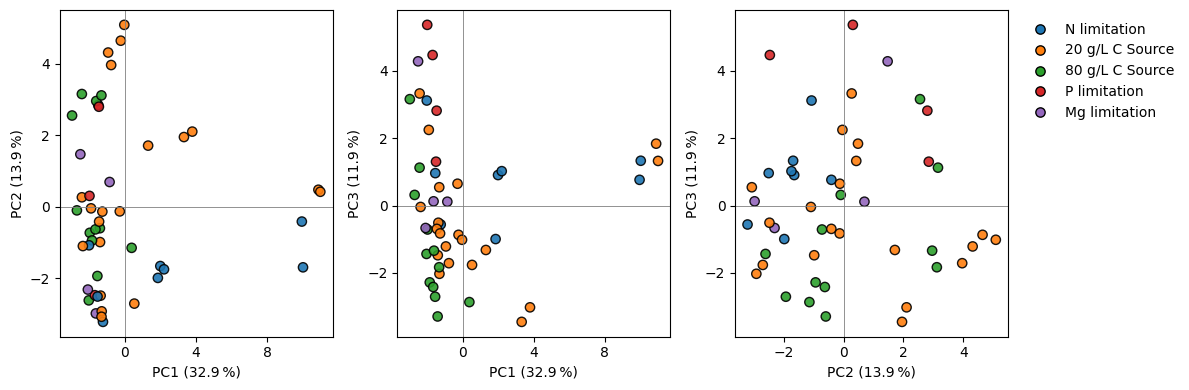

In [9]:
pca_model = pca_scatter3(ica_data.A[shaken_metadata.index], labels=shaken_metadata['Limitation'].tolist(), scale=True, label_points=False,name='tpm_pca_shaken_limitation')

Text(0.5, 1.0, 'PC3 loadings')

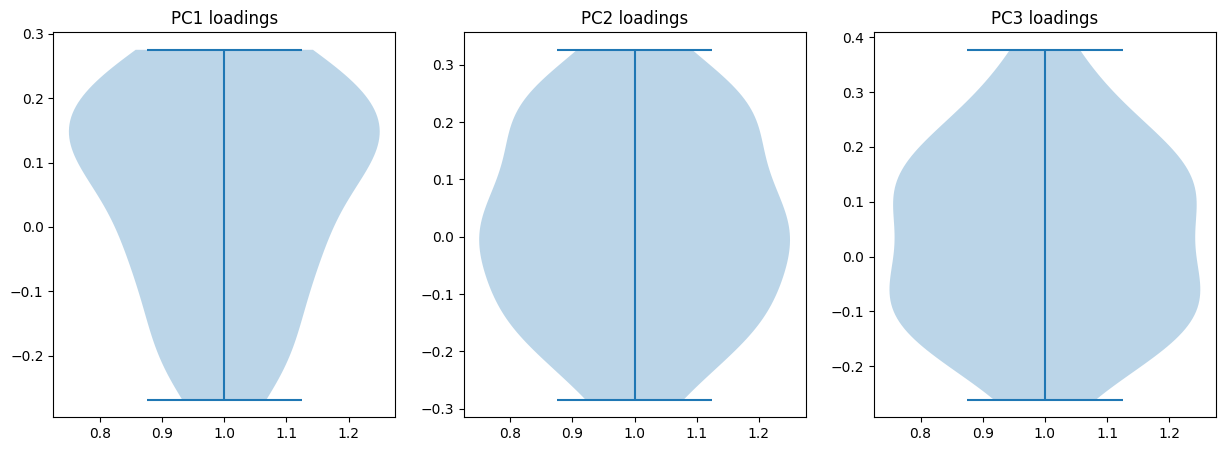

In [10]:
loadings = pd.DataFrame(pca_model.components_).T

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.violinplot(loadings[0])
plt.title('PC1 loadings')

plt.subplot(1,3,2)
plt.violinplot(loadings[1])
plt.title('PC2 loadings')

plt.subplot(1,3,3)
plt.violinplot(loadings[2])
plt.title('PC3 loadings')

Biplot for PC1 and PC2

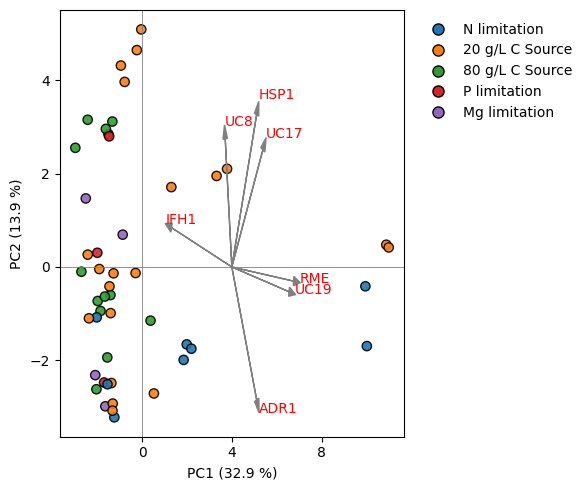

In [11]:
# Standardize and PCA
df = ica_data.A[shaken_metadata.index]
X  = StandardScaler().fit_transform(df.T.values)

labels = pd.Series(shaken_metadata['Limitation'])  # only color coding

PCs  = pca_model.fit_transform(X)
expl = pca_model.explained_variance_ratio_ * 100

# --- Color map for Limitation --------------------------------
uniq_labels = labels.unique()
palette     = plt.get_cmap('tab10').colors
colours     = labels.map(lambda z: palette[list(uniq_labels).index(z) % len(palette)])

# --- Scatter plot (all circles) ------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(PCs[:, 0], PCs[:, 1], 
           c=colours, 
           s=45, alpha=0.9, edgecolor='k', marker='o')

# Axes formatting
ax.set_xlabel(f"PC1 ({expl[0]:.1f} %)")
ax.set_ylabel(f"PC2 ({expl[1]:.1f} %)")
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.axhline(0, color='grey', lw=0.6)
ax.axvline(0, color='grey', lw=0.6)

# Legend for Limitation only
handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=palette[i % len(palette)],
                      markeredgecolor='k', markersize=8)
           for i in range(len(uniq_labels))]
ax.legend(handles, uniq_labels, frameon=False,
          bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Arrows for biplot (unchanged) ----------------------------
loadings = pd.DataFrame(pca_model.components_).T
loadings.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3'}, inplace=True)

pc1_loadings = [33,3,24]
pc2_loadings = [14,4,13,34]

arrows_to_make = pc1_loadings + pc2_loadings
arrow_length = 10
text_scale = 1.1
start1, start2 = 4, 0

for g in arrows_to_make:
    g_weight_pc1 = loadings.loc[g, 'PC1'] * arrow_length
    g_weight_pc2 = loadings.loc[g, 'PC2'] * arrow_length
    ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width=0.2, color='grey')
    ax.text(start1 + (text_scale * g_weight_pc1),
            start2 + (text_scale * g_weight_pc2),
            ica_data.imodulon_table['iModulon Name'][g], size=10, color='red')

plt.tight_layout()
plt.show()


Biplot for PC1 and PC3

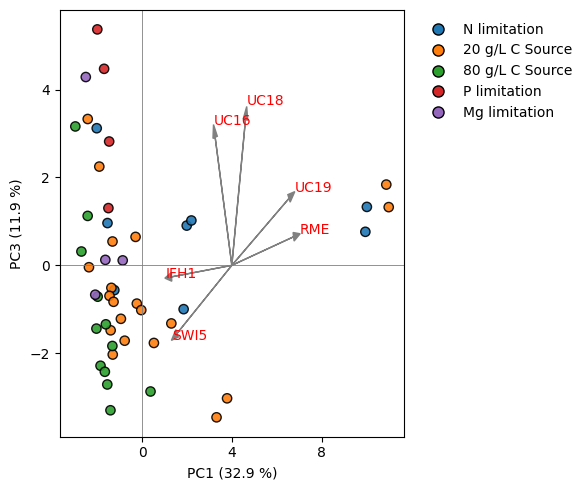

In [12]:
# Standardize and PCA
df = ica_data.A[shaken_metadata.index]
X  = StandardScaler().fit_transform(df.T.values)

labels = pd.Series(shaken_metadata['Limitation'])  # only color coding

PCs  = pca_model.fit_transform(X)
expl = pca_model.explained_variance_ratio_ * 100

# --- Color map for Limitation --------------------------------
uniq_labels = labels.unique()
palette     = plt.get_cmap('tab10').colors
colours     = labels.map(lambda z: palette[list(uniq_labels).index(z) % len(palette)])

# --- Scatter plot (all circles) ------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(PCs[:, 0], PCs[:, 2], 
           c=colours, 
           s=45, alpha=0.9, edgecolor='k', marker='o')

# Axes formatting
ax.set_xlabel(f"PC1 ({expl[0]:.1f} %)")
ax.set_ylabel(f"PC3 ({expl[2]:.1f} %)")
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.axhline(0, color='grey', lw=0.6)
ax.axvline(0, color='grey', lw=0.6)

# Legend for Limitation only
handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=palette[i % len(palette)],
                      markeredgecolor='k', markersize=8)
           for i in range(len(uniq_labels))]
ax.legend(handles, uniq_labels, frameon=False,
          bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Arrows for biplot (unchanged) ----------------------------
loadings = pd.DataFrame(pca_model.components_).T
loadings.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3'}, inplace=True)

pc1_loadings = [33,3,24]
pc3_loadings = [6, 36, 32]

arrows_to_make = pc1_loadings + pc3_loadings
arrow_length = 10
text_scale = 1.1
start1, start2 = 4, 0

for g in arrows_to_make:
    g_weight_pc1 = loadings.loc[g, 'PC1'] * arrow_length
    g_weight_pc2 = loadings.loc[g, 'PC3'] * arrow_length
    ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width=0.2, color='grey')
    ax.text(start1 + (text_scale * g_weight_pc1),
            start2 + (text_scale * g_weight_pc2),
            ica_data.imodulon_table['iModulon Name'][g], size=10, color='red')

plt.tight_layout()
plt.show()


pH response

In [13]:
from plotting import *

19


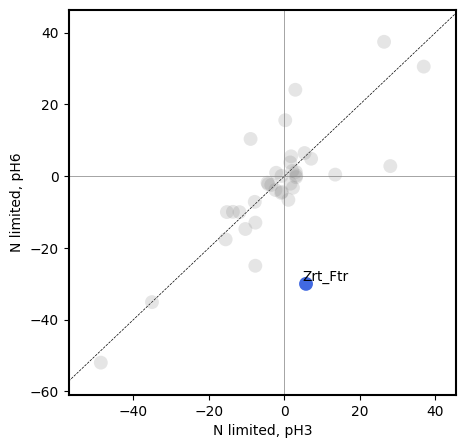

In [21]:
ax,df_diff = plot_dima_local(ica_data,'Batch_Shaken:Glucose_Nlimit_pH3','Batch_Shaken:Glucose_Nlimit_pH6',color_inputs='royalblue',xlabel_to_plot='N limited, pH3',ylabel_to_plot='N limited, pH6');
ax.figure.set_size_inches(5, 5)
# Save the plot to a file (e.g., in PNG format)
#plt.savefig('92vs148.png', dpi=300, bbox_inches='tight')
#plt.xlabel('FermNull',fontsize=14)
#plt.ylabel('EV_FermNull',fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

#plt.savefig('dima_Fermnull_Ev0_Fermnull.pdf',format='pdf', bbox_inches='tight',dpi=600)
# Display the plot (optional)
plt.show()

19


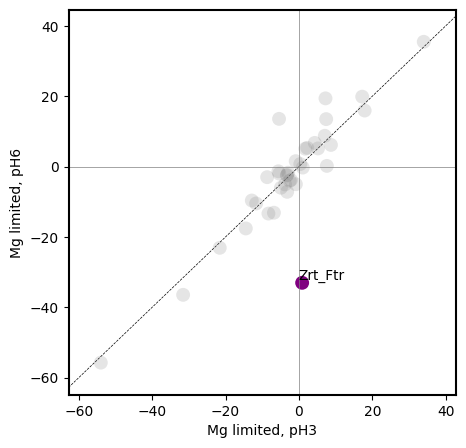

In [20]:
ax,df_diff = plot_dima_local(ica_data,'Batch_Shaken:Glucose_Mglimit_pH3','Batch_Shaken:Glucose_Mglimit_pH6',color_inputs='purple',xlabel_to_plot='Mg limited, pH3',ylabel_to_plot='Mg limited, pH6');
ax.figure.set_size_inches(5, 5)

19


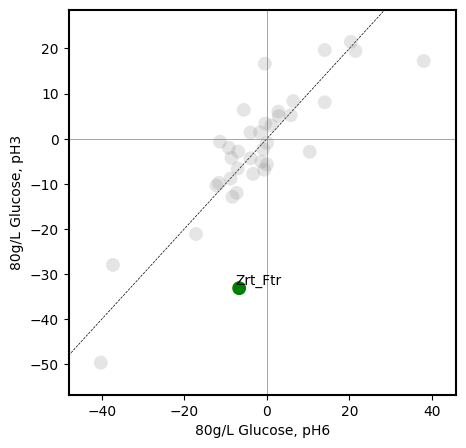

In [19]:
ax,df_diff = plot_dima_local(ica_data,'Batch_Shaken:High glucose_mediumDO_pH3','Batch_Shaken:High glucose_mediumDO_pH6',color_inputs='green',xlabel_to_plot='80g/L Glucose, pH6',ylabel_to_plot='80g/L Glucose, pH3');
ax.figure.set_size_inches(5, 5)

19


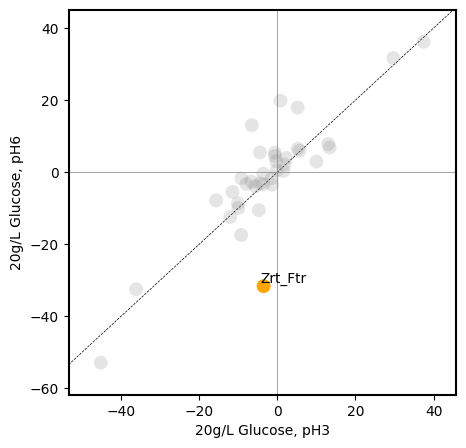

In [18]:
ax,df_diff = plot_dima_local(ica_data,'Batch_Shaken:Glucose_mediumDO_pH3','Batch_Shaken:Glucose_mediumDO_pH6',color_inputs='orange',xlabel_to_plot='20g/L Glucose, pH3',ylabel_to_plot='20g/L Glucose, pH6');
ax.figure.set_size_inches(5, 5)

In [45]:
for w in ica_data.view_imodulon(19)[abs(ica_data.view_imodulon(19)['gene_weight'])>0.02]['Preferred_name'].dropna().tolist():
    if('-' not in w):
        print(w)



OPT6
ENA2
DCW1
HGT1
CDR1
DUR3
FRE3
FRE3
RIM101
FGR2
HIP1
RIM21
DIP5
CPYA
MDR1
PTH2
NRG1
GIT2
GIT2
HIP1
CDR1
OPT6
mug86
UGA4
ZRT1
GAS5
PMC1
FTR1
FET3
FTR1
TNA1
EFM6
BIO2
PTH2
GAT1
MNN4
SSA2
SSA2
ZRT1
2
CAR1
TXNDC8
OPT6
phoA
exgA
OPT6
OPT6
ZRT1
RCH1
OPT6
CCP1
ZRT2
SSA2
phoA
TNA1
FCY21


In [40]:
ica_data.view_imodulon(19)[abs(ica_data.view_imodulon(19)['gene_weight'])>0.06]

,gene_weight,accession,source,feature,start,end,score,strand,phase,attributes,...,sacc_gene_product,COG_category,Description,Preferred_name,GOs,PFAMs,KEGG_Pathway,KEGG_Module,BRITE,regulator
YALI1_A01394g,-0.077335,NC_090770.1,RefSeq,CDS,139487.0,142723.0,.,+,0,ID=cds-XP_499639.2;Parent=rna-XM_499639.3;Dbxr...,...,putative Na(+)-exporting P-type ATPase ENA5,P,Belongs to the cation transport ATPase (P-type...,ENA2,"GO:0000322,GO:0000323,GO:0000324,GO:0003674,GO...","Cation_ATPase,Cation_ATPase_C,Cation_ATPase_N,...",-,-,"ko00000,ko01000","CBF1,CBF1,CRZ1,GAT1,GLN3,MBP1,MET32,MIG1,MIG2,..."
YALI1_A04155r,0.090323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YALI1_A17983g,0.118688,NC_090770.1,RefSeq,CDS,1798337.0,1798343.0,.,+,0,ID=cds-XP_068137947.1;Parent=rna-XM_068281846....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YALI1_B01065g,0.061402,NC_090771.1,RefSeq,CDS,106525.0,106539.0,.,+,0,ID=cds-XP_068138016.1;Parent=rna-XM_068281915....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YALI1_B12489g,-0.086278,NC_090771.1,RefSeq,CDS,1248934.0,1250049.0,.,+,0,ID=cds-XP_500677.3;Parent=rna-XM_500677.3;Dbxr...,...,NaN,G,Saccharomyces cerevisiae YJR107w,-,-,Lipase_3,-,-,"ko00000,ko01000",NaN
YALI1_B17363g,0.123873,NC_090771.1,RefSeq,CDS,1734201.0,1736360.0,.,-,0,ID=cds-XP_500826.1;Parent=rna-XM_500826.1;Dbxr...,...,NaN,PQ,ferric reductase,FRE3,"GO:0000041,GO:0000293,GO:0000322,GO:0000323,GO...","FAD_binding_8,Ferric_reduct,NAD_binding_6",-,-,-,NaN
YALI1_B23522g,-0.062874,NC_090771.1,RefSeq,CDS,2352220.0,2352969.0,.,+,0,ID=cds-XP_068138212.1;Parent=rna-XM_068282111....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YALI1_B24836g,-0.064798,NC_090771.1,RefSeq,CDS,2483617.0,2485281.0,.,+,0,ID=cds-XP_501081.1;Parent=rna-XM_501081.1;Dbxr...,...,NaN,S,Inorganic phosphate,FGR2,-,"MFS_1,Sugar_tr",-,-,-,NaN
YALI1_B25506g,-0.071931,NC_090771.1,RefSeq,CDS,2550615.0,2552204.0,.,+,0,ID=cds-XP_501098.1;Parent=rna-XM_501098.3;Dbxr...,...,NaN,EGP,)transporter,-,-,"MFS_1,Sugar_tr",-,-,"ko00000,ko02000",NaN
YALI1_B26845g,0.063476,NC_090771.1,RefSeq,CDS,2684534.0,2685712.0,.,+,0,ID=cds-XP_501140.1;Parent=rna-XM_501140.3;Dbxr...,...,aspartyl protease,O,Belongs to the peptidase A1 family,-,-,-,-,-,-,"CRZ1,MSN2,STE12,SWI4"
